In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import mplcyberpunk
plt.style.use("cyberpunk")

In [ ]:
def load_documents(data_dir):
    documents = []
    doc_labels = []
    doc_ids = []
    
    for class_dir in sorted(os.listdir(data_dir)):
        if os.path.isdir(os.path.join(data_dir, class_dir)) and class_dir.isdigit():
            class_label = int(class_dir)
            for file in os.listdir(os.path.join(data_dir, class_dir)):
                if file.endswith('.tsv'):
                    file_path = os.path.join(data_dir, class_dir, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = f.readlines()
                        doc_text = ' '.join([line.split('\t')[0] for line in lines if line.strip()])
                        documents.append(doc_text)
                        doc_labels.append(class_label)
                        doc_ids.append(file.replace('.tsv', ''))
    
    return documents, doc_labels, doc_ids

train_dir = '/path/to/annotated-corpus/train/'
test_dir = '/path/to/annotated-corpus/test/'

train_docs, train_labels, train_ids = load_documents(train_dir)
test_docs, test_labels, test_ids = load_documents(test_dir)

print(f'Количество обучающих документов: {len(train_docs)}')
print(f'Количество тестовых документов: {len(test_docs)}')
print(f'Количество классов: {len(set(train_labels))}')

Количество обучающих документов: 120000
Количество тестовых документов: 7600
Количество классов: 4


In [4]:
vectorizer = CountVectorizer(max_features=10000, min_df=5, stop_words="english", token_pattern=r'\b[a-zA-Z]{3,}\b')

train_term_doc_matrix = vectorizer.fit_transform(train_docs)
test_term_doc_matrix = vectorizer.transform(test_docs)

print(f'Размерность матрицы термин-документ (обучающая): {train_term_doc_matrix.shape}')
print(f'Размерность матрицы термин-документ (тестовая): {test_term_doc_matrix.shape}')

feature_names = vectorizer.get_feature_names_out()
print(f'Количество уникальных слов: {len(feature_names)}')

Размерность матрицы термин-документ (обучающая): (120000, 10000)
Размерность матрицы термин-документ (тестовая): (7600, 10000)
Количество уникальных слов: 10000


In [5]:
n_topics_list = [2, 5, 10, 20, 40]
n_topics_class_count = len(set(train_labels))
n_topics_list.append(n_topics_class_count)
n_topics_list = sorted(n_topics_list)

lda_models = {}
perplexities = {}
top_words = {}
doc_topic_probs = {}

for n_topics in n_topics_list:
    print(f'Обучение LDA с {n_topics} темами')
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
    lda.fit(train_term_doc_matrix)
    
    lda_models[n_topics] = lda
    
    perplexity = lda.perplexity(test_term_doc_matrix)
    perplexities[n_topics] = perplexity
    print(f'Perplexity: {perplexity:.4f}')
    
    top_words[n_topics] = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words[n_topics].append([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])
    print('Топ-10 слов для каждой темы:')
    for i, words in enumerate(top_words[n_topics]):
        print(f'  Тема {i+1}: {", ".join(words[:10])}')
    
    doc_topic_probs[n_topics] = lda.transform(train_term_doc_matrix)
    
    topic_prob_df = pd.DataFrame(doc_topic_probs[n_topics], 
                                 columns=[f'Topic_{i+1}' for i in range(n_topics)])
    topic_prob_df.insert(0, 'Document_ID', train_ids)
    
    filename = f'document_topic_probabilities_{n_topics}topics.tsv'
    topic_prob_df.to_csv(filename, sep='\t', index=False)

Обучение LDA с 2 темами
Perplexity: 4504.1146
Топ-10 слов для каждой темы:
  Тема 1: new, reuters, year, said, company, world, york, corp, game, million
  Тема 2: said, reuters, president, new, oil, quot, government, people, iraq, wednesday
Обучение LDA с 4 темами
Perplexity: 5122.0393
Топ-10 слов для каждой темы:
  Тема 1: new, quot, company, year, game, internet, software, computer, microsoft, said
  Тема 2: president, said, quot, minister, reuters, security, united, prime, bush, government
  Тема 3: said, people, reuters, company, million, iraq, killed, group, yesterday, thursday
  Тема 4: reuters, new, york, prices, oil, fullquote, year, quarter, stocks, percent
Обучение LDA с 5 темами
Perplexity: 5131.7267
Топ-10 слов для каждой темы:
  Тема 1: new, software, microsoft, company, internet, computer, said, corp, technology, service
  Тема 2: said, president, minister, iraq, reuters, government, quot, united, prime, bush
  Тема 3: said, people, company, million, reuters, billion, cou

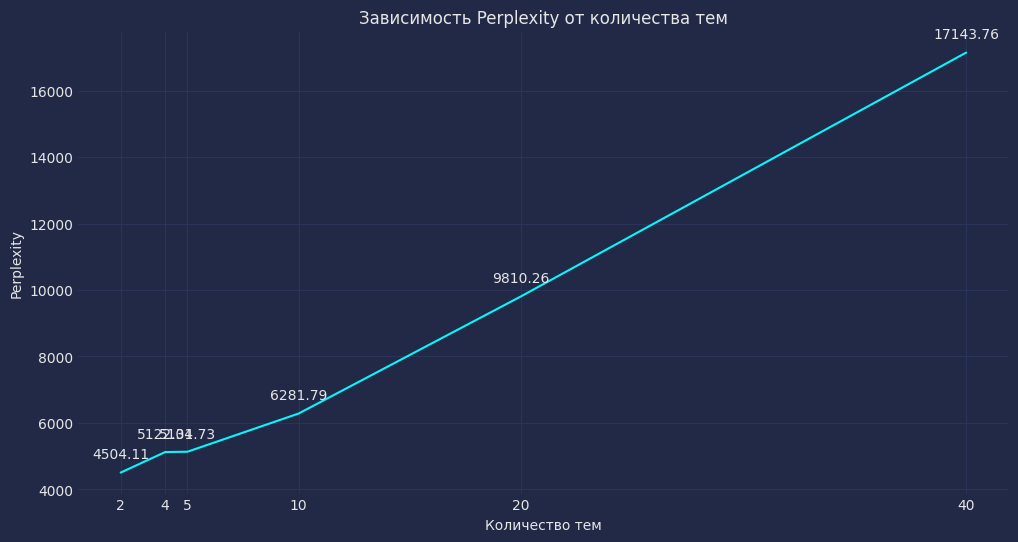

Значения perplexity для каждого количества тем:
2 тем: perplexity = 4504.1146
4 тем: perplexity = 5122.0393
5 тем: perplexity = 5131.7267
10 тем: perplexity = 6281.7912
20 тем: perplexity = 9810.2582
40 тем: perplexity = 17143.7575


In [6]:
n_topics_values = list(perplexities.keys())
perplexity_values = list(perplexities.values())

plt.figure(figsize=(12, 6))
plt.plot(n_topics_values, perplexity_values)
plt.xlabel('Количество тем')
plt.ylabel('Perplexity')
plt.title('Зависимость Perplexity от количества тем')
plt.grid(True)
plt.xticks(n_topics_values)
for i in range(len(n_topics_values)):
    plt.annotate(f'{perplexity_values[i]:.2f}', (n_topics_values[i], perplexity_values[i]), 
                textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

print('Значения perplexity для каждого количества тем:')
for n_topics, perplexity in perplexities.items():
    print(f'{n_topics} тем: perplexity = {perplexity:.4f}')

Полином 2 степени: r² = 0.9987
Полином 3 степени: r² = 0.9996
Полином 4 степени: r² = 0.9998

Лучшая аппроксимация: Полином 4 степени с r² = 0.9998


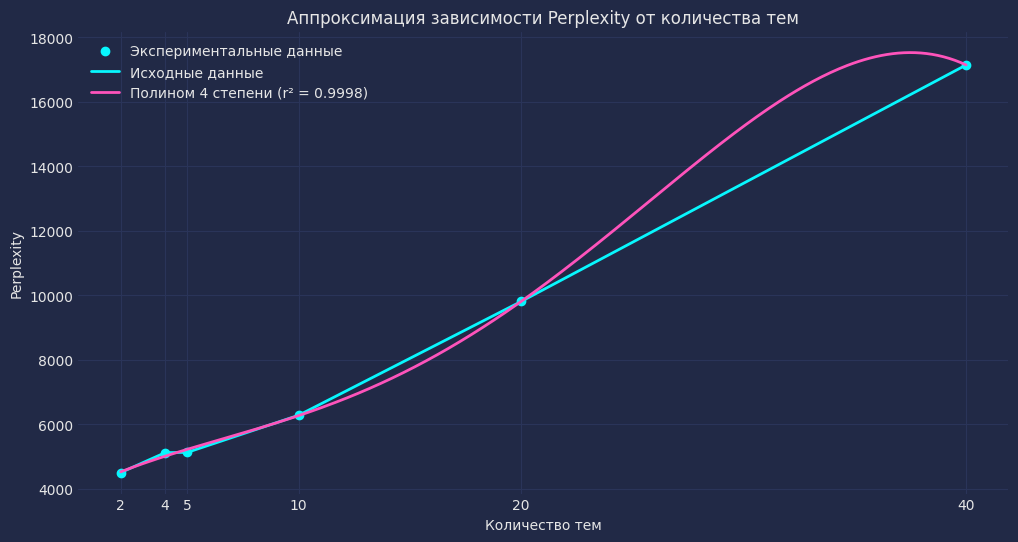

In [7]:
x = np.array(n_topics_values)
y = np.array(perplexity_values)

def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def poly4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

functions = [poly2, poly3, poly4]
function_names = ['Полином 2 степени', 'Полином 3 степени', 'Полином 4 степени']

best_r2 = -float('inf')
best_func = None
best_params = None

for func, name in zip(functions, function_names):
    popt, _ = curve_fit(func, x, y)
    
    y_pred = func(x, *popt)
    
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f'{name}: r² = {r2:.4f}')
    
    if r2 > best_r2:
        best_r2 = r2
        best_func = func
        best_params = popt
        best_name = name

print(f'\nЛучшая аппроксимация: {best_name} с r² = {best_r2:.4f}')

plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Экспериментальные данные')
plt.plot(n_topics_values, perplexity_values, linewidth=2, label='Исходные данные')

x_smooth = np.linspace(min(x), max(x), 300)
y_smooth = best_func(x_smooth, *best_params)
plt.plot(x_smooth, y_smooth, label=f'{best_name} (r² = {best_r2:.4f})', linewidth=2)

plt.xlabel('Количество тем')
plt.ylabel('Perplexity')
plt.title('Аппроксимация зависимости Perplexity от количества тем')
plt.legend()
plt.grid(True)
plt.xticks(n_topics_values)
plt.show()

In [8]:
optimal_n_topics = n_topics_values[perplexity_values.index(min(perplexity_values))]
min_perplexity = min(perplexity_values)

print(f'Оптимальное количество тем: {optimal_n_topics} (perplexity = {min_perplexity:.4f})')
print(f'Лучшая аппроксимация: {best_name} с r² = {best_r2:.4f}')

print(f'\nТоп-10 слов для оптимальной модели ({optimal_n_topics} тем):')
for i, words in enumerate(top_words[optimal_n_topics]):
    print(f'  Тема {i+1}: {", ".join(words[:10])}')

optimal_doc_topic_probs = doc_topic_probs[optimal_n_topics]
print(f'\nРазмерность матрицы вероятностей документов к темам (оптимальная модель): {optimal_doc_topic_probs.shape}')
print('Пример вероятностей принадлежности первого документа к темам:')
print(optimal_doc_topic_probs[0])

print(f'\nДокументы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):')
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_idx = np.argmax(doc_probs)
    top_prob = doc_probs[top_doc_idx]
    print(f'  Тема {topic_idx+1}: документ #{top_doc_idx} (вероятность = {top_prob:.4f}, класс = {train_labels[top_doc_idx]})')

Оптимальное количество тем: 2 (perplexity = 4504.1146)
Лучшая аппроксимация: Полином 4 степени с r² = 0.9998

Топ-10 слов для оптимальной модели (2 тем):
  Тема 1: new, reuters, year, said, company, world, york, corp, game, million
  Тема 2: said, reuters, president, new, oil, quot, government, people, iraq, wednesday

Размерность матрицы вероятностей документов к темам (оптимальная модель): (120000, 2)
Пример вероятностей принадлежности первого документа к темам:
[0.03220586 0.96779414]

Документы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):
  Тема 1: документ #89377 (вероятность = 0.9927, класс = 3)
  Тема 2: документ #26348 (вероятность = 0.9896, класс = 1)


In [9]:
optimal_n_topics = n_topics_values[perplexity_values.index(min(perplexity_values))]
optimal_doc_topic_probs = doc_topic_probs[optimal_n_topics]

print(f'\nРазмерность матрицы вероятностей документов к темам (оптимальная модель): {optimal_doc_topic_probs.shape}')
print('Пример вероятностей принадлежности первого документа к темам:')
print(optimal_doc_topic_probs[0])

topic_prob_df = pd.DataFrame(optimal_doc_topic_probs, 
                             columns=[f'Topic_{i+1}' for i in range(optimal_n_topics)])
topic_prob_df.insert(0, 'Document_ID', train_ids)

topic_prob_df.to_csv('document_topic_probabilities.tsv', sep='\t', index=False)
print(f'\nВероятности принадлежности документов к темам сохранены в файл: document_topic_probabilities.tsv')
print(f'Файл содержит вероятности для {optimal_n_topics} тем для {len(train_ids)} документов')

print(f'\nДокументы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):')
top_docs_per_topic = []
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_idx = np.argmax(doc_probs)
    top_prob = doc_probs[top_doc_idx]
    top_docs_per_topic.append((top_doc_idx, top_prob))
    print(f'  Тема {topic_idx+1}: документ #{top_doc_idx} (ID: {train_ids[top_doc_idx]}, вероятность = {top_prob:.4f}, класс = {train_labels[top_doc_idx]})')

print(f'\nТоп-5 документов для каждой темы (с наибольшей вероятностью принадлежности):')
top_k = 5
for topic_idx in range(optimal_n_topics):
    doc_probs = optimal_doc_topic_probs[:, topic_idx]
    top_doc_indices = np.argsort(doc_probs)[::-1][:top_k]
    print(f'  Тема {topic_idx+1}:')
    for i, doc_idx in enumerate(top_doc_indices):
        prob = doc_probs[doc_idx]
        print(f'    {i+1}. Документ #{doc_idx} (ID: {train_ids[doc_idx]}, вероятность = {prob:.4f}, класс = {train_labels[doc_idx]})')


Размерность матрицы вероятностей документов к темам (оптимальная модель): (120000, 2)
Пример вероятностей принадлежности первого документа к темам:
[0.03220586 0.96779414]

Вероятности принадлежности документов к темам сохранены в файл: document_topic_probabilities.tsv
Файл содержит вероятности для 2 тем для 120000 документов

Документы с самой высокой вероятностью принадлежности к каждой теме (оптимальная модель):
  Тема 1: документ #89377 (ID: 118462, вероятность = 0.9927, класс = 3)
  Тема 2: документ #26348 (ID: 16499, вероятность = 0.9896, класс = 1)

Топ-5 документов для каждой темы (с наибольшей вероятностью принадлежности):
  Тема 1:
    1. Документ #89377 (ID: 118462, вероятность = 0.9927, класс = 3)
    2. Документ #60569 (ID: 59239, вероятность = 0.9923, класс = 3)
    3. Документ #72651 (ID: 118330, вероятность = 0.9923, класс = 3)
    4. Документ #103584 (ID: 88353, вероятность = 0.9917, класс = 4)
    5. Документ #113594 (ID: 95660, вероятность = 0.9917, класс = 4)
  Тем

In [15]:
selected_n_topics = 2

original_iterations = 10
iteration_counts = [original_iterations//2, original_iterations, original_iterations*2]

iteration_results = {}

for iterations in iteration_counts:
    print(f'Обучение LDA с {selected_n_topics} темами и {iterations} итерациями')
    
    lda = LatentDirichletAllocation(n_components=selected_n_topics, random_state=42, max_iter=iterations)
    lda.fit(train_term_doc_matrix)
    
    perplexity = lda.perplexity(test_term_doc_matrix)
    iteration_results[iterations] = perplexity
    
    print(f'Perplexity: {perplexity:.4f}')

Обучение LDA с 2 темами и 5 итерациями


Perplexity: 4577.9084
Обучение LDA с 2 темами и 10 итерациями
Perplexity: 4504.1146
Обучение LDA с 2 темами и 20 итерациями
Perplexity: 4454.0311
